In [1]:

import torch
from time import time
from DocBuilder.utils import split_list_to_batch, restore_batched_list, unbind_sparse, top_k_sparse, tensor_retuen_type
from DocBuilder.Retriever_k_means import cluster_builder
import matplotlib.pyplot as plt
import numpy as np

/root/miniconda3/envs/RR/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


542


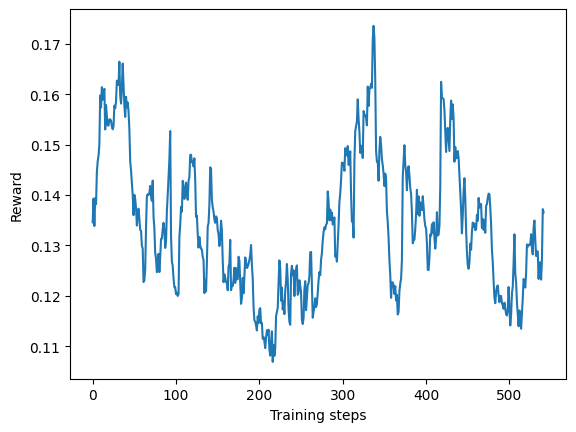

In [5]:

with open("reward_number.txt", "r") as f:
    r = f.readlines()
r = [float(i) for i in r][:]
print(len(r))
moving_avg = []
ma = np.mean(r[:500])
ratio=1-20/len(r)
for x in r:
    ma = ratio * ma + (1-ratio) * x
    moving_avg.append(ma)

plt.ylabel("Reward")
plt.xlabel("Training steps")
plt.plot(moving_avg)
plt.show()

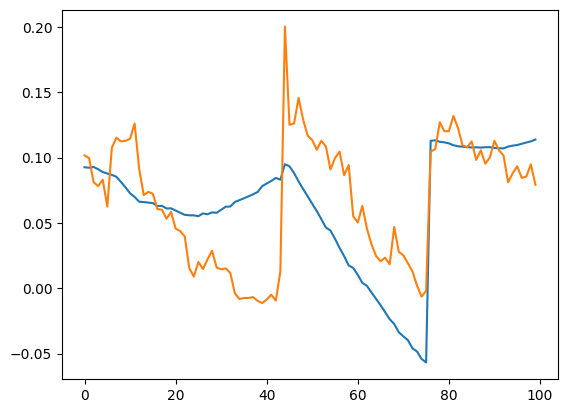

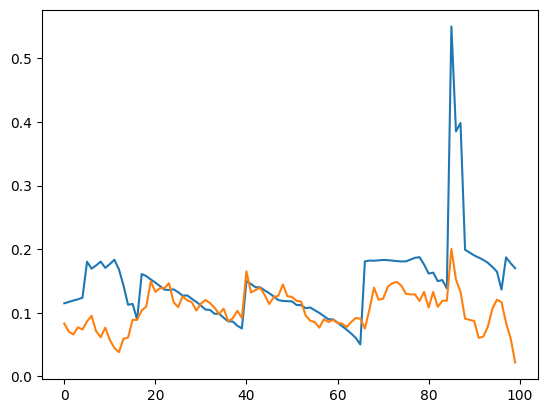

In [4]:
returns = torch.load("save/return.pt")
value = torch.load("save/value.pt")
plt.plot(returns[:100])
plt.plot(value[:100])
plt.show()
plt.plot(returns[100:200])
plt.plot(value[100:200])
plt.show()

In [44]:
from LM.llama_reader import LLaMa_reader
import config
from metric.reward import Bert_score
g_config= config.generate_config
g_config.temperature=0.1
model = LLaMa_reader(config.LM_dir, device="cuda:1",generate_config=g_config)

Loading checkpoint shards: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

["\nson Sav\nbornarch 2, 1931 -June 2, 1013) was an American actor best film person, best commonly for his port as Young young George Bailey in the's a Wonderful Life ("]


(tensor(0.6838),)

In [166]:

# output = model.generate("hello", max_new_tokens=20)
messages = "who is young george bailey in it's a wonderful life"
y = "Robert James Anderson (March 6, 1933--June 6, 2008) was an American actor and television producer, most famous for his role as the young George Bailey in It's a Wonderful Life."
response = model.pseudo_generate(messages, y, temperture=0.2, return_prob=False, decode=True)
print(response)
Bert_score([y], response)

["\nson Brad\nbornarch 2, 1939 -June 2, 1013) was an American actor best film person. best famous for his role as Young young George Bailey in the's a Wonderful Life ("]


(tensor(0.7152),)

In [8]:
token, prob = model.pseudo_generate("hello!","I'm Amber and I'm so glad you're here!", temperture=0.5,return_prob=True)

In [46]:

from transformers import BertModel, BertConfig, BertTokenizer, RobertaModel, RobertaTokenizer, RobertaForMaskedLM
import config, torch
bert = RobertaModel.from_pretrained(config.roberta_dir, torch_dtype=torch.bfloat16).to(torch.bfloat16)
print(bert)
embedding = bert.roberta.embeddings.position_embeddings
new_embedding = torch.nn.Embedding(1026, embedding.embedding_dim, dtype = torch.bfloat16)
new_embedding.weight.data[:len(embedding.weight),:]=embedding.weight.data
bert.roberta.embeddings.position_embeddings = new_embedding

bert.roberta.embeddings.register_buffer(
    "position_ids", torch.arange(1026).expand((1, -1)), persistent=False
)
bert.roberta.embeddings.register_buffer(
    "token_type_ids", torch.zeros(bert.roberta.embeddings.position_ids.size(), dtype=torch.long), persistent=False
)
tokenizer = RobertaTokenizer.from_pretrained(config.roberta_dir)
t=tokenizer("".join([" retrieve"," proceed"," rewrite"]*300), return_tensors="pt")
bert(**t)

Some weights of RobertaModel were not initialized from the model checkpoint at huggingface/roberta_head/ and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

AttributeError: 'RobertaModel' object has no attribute 'roberta'

In [5]:

from config import enc_size_config, bert_dir, enc_config
from LM.Knowledge_encoder import KnowEncoder
import torch
Encoder=KnowEncoder(dims = 4096, **enc_config, dtype=torch.bfloat16)

output = Encoder.forward(['hello 1','hello 2','hello 3','hello 4','hello 5','hello 6'], 3)
print(len(output))
print([output[i].shape for i in range(len(output))])
print(output[0].grad_fn, output[-1].grad_fn)

16
[torch.Size([2, 8, 4096]), torch.Size([2, 8, 4096]), torch.Size([2, 8, 4096]), torch.Size([2, 8, 4096]), torch.Size([2, 8, 4096]), torch.Size([2, 8, 4096]), torch.Size([2, 8, 4096]), torch.Size([2, 8, 4096]), torch.Size([2, 8, 4096]), torch.Size([2, 8, 4096]), torch.Size([2, 8, 4096]), torch.Size([2, 8, 4096]), torch.Size([2, 8, 4096]), torch.Size([2, 8, 4096]), torch.Size([2, 8, 4096]), torch.Size([2, 24, 4096])]
<UnbindBackward0 object at 0x7668ddd03760> <UnsafeViewBackward0 object at 0x7668ddd02950>


In [3]:
from DatasetLoader.collate_func import collate
q, a = collate().templete("which president of the united states was a boy scout", "Eagle Scout is the highest rank one can receive in BSA. A Scout who attains this rank is called an Eagle Scout. Since its introduction in 1911, the Eagle Scout rank has been earned by more than two million young men. Requirements include earning at least 21 merit badges and demonstrating Scout Spirit through the Boy Scout Oath and Law, service, and leadership all before or by age 18. This includes an extensive service project that the Scout plans, organizes, leads, and manages. Eagle Scouts are presented with a medal and a badge that visibly recognizes the accomplishments of the Scout. Additional recognition can be earned through Eagle Palms, awarded for completing additional tenure, leadership, and merit badge requirements. Many famous Americans are Eagle Scouts: astronaut Neil Armstrong, film director Michael Moore, TV host Mike Rowe, Steven Spielberg, Mayor Michael Bloomberg, Secretary of Defense Robert Gates, and President Gerald Ford are just a small sample of Eagle Scouts.")
len(collate().LMtokenizer(q).input_ids)

261